# Mohammad Amin Rami
# 98101588
# HW4
# Question 1


In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from io import open
import string
import re
import random
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self):
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOF"}
        self.word2count = {}
        self.n_words = 2

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [3]:
lang = Lang()
data_path = "ferdousi.txt"
data = []
max_length = 0

with open(data_path) as file:
    next(file)
    next(file)
    while True:
        try:
            first_mesra = next(file).strip()
            second_mesra = next(file).strip()
            data.append((first_mesra, second_mesra))
            
            lang.add_sentence(first_mesra)
            lang.add_sentence(second_mesra)
            max_length = len(first_mesra.split(' ')) if len(first_mesra.split(' ')) > max_length else max_length 
            max_length = len(second_mesra.split(' ')) if len(second_mesra.split(' ')) > max_length else max_length
            
        except StopIteration:
            break

max_length += 2


In [4]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(lang, pair):
    input_tensor = tensorFromSentence(lang, pair[0]).to(device)
    target_tensor = tensorFromSentence(lang, pair[1]).to(device)
    return (input_tensor, target_tensor)


In [58]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.xlabel('sample/300')
    plt.ylabel('loss')
    plt.show()

### Part A: LSTM

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, x, h):
        embedded = self.embedding(x).view(1, 1, -1)
        output, hidden = self.lstm(embedded, h)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        output = self.embedding(x).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, h)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [8]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length):
    encoder_hidden = encoder.initHidden()
    encoder_hidden = (encoder_hidden, torch.zeros_like(encoder_hidden))

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [9]:
def trainIters(pairs, encoder, decoder, lang, max_length, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    for i, training_pair in enumerate(pairs):
        input_tensor = tensorFromSentence(lang, training_pair[0])
        target_tensor = tensorFromSentence(lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, max_length)
        print_loss_total += loss
        plot_loss_total += loss
        if (i + 1) == 100:
            print_loss_avg = print_loss_total / 100
            print(f'train loss:      {print_loss_avg:0.2f}       iteration {i+1}/{len(pairs)}')
        if (i + 1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'train loss:      {print_loss_avg:0.2f}       iteration {i+1}/{len(pairs)}')

        if (i + 1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [10]:
input_size = len(lang.word2index)
hidden_size = 120

encoder = EncoderRNN(input_size, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, input_size).to(device)


In [11]:
loss = []
epochs = 5
max_data = 40000
for epoch in range(epochs):
    try:
        print(f"============== epoch {epoch + 1} ==============")
        epoch_loss = trainIters(data[:max_data], encoder, decoder, lang, max_length, print_every=5000, plot_every=300, learning_rate=0.025)
        loss.extend(epoch_loss)
    except KeyboardInterrupt:
        print('Training finished')
        break


============== epoch 1 ==============
train loss:      8.49       iteration 100/40000
train loss:      6.37       iteration 5000/40000
train loss:      5.83       iteration 10000/40000
train loss:      5.71       iteration 15000/40000
train loss:      5.73       iteration 20000/40000
train loss:      5.65       iteration 25000/40000
train loss:      5.46       iteration 30000/40000
train loss:      5.41       iteration 35000/40000
train loss:      5.38       iteration 40000/40000
============== epoch 2 ==============
train loss:      5.64       iteration 100/40000
train loss:      5.36       iteration 5000/40000
train loss:      5.09       iteration 10000/40000
train loss:      5.03       iteration 15000/40000
train loss:      5.13       iteration 20000/40000
train loss:      5.07       iteration 25000/40000
train loss:      4.88       iteration 30000/40000
train loss:      4.88       iteration 35000/40000
train loss:      4.88       iteration 40000/40000
============== epoch 3 =======

In [12]:
def evaluate(encoder, decoder, sentence, input_lang, max_length=13):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_hidden = (encoder_hidden, torch.zeros_like(encoder_hidden))

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(input_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
        decoded_words =  ' '.join(decoded_words[:-1])
        return decoded_words


<Figure size 640x480 with 0 Axes>

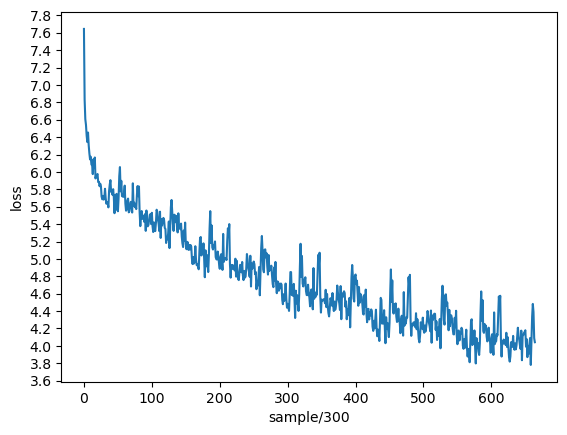

In [59]:
showPlot(loss)

In [64]:
random_indices = [43269, 13098, 46168, 15802, 17594, 37723, 38583, 15911, 23462, 13303]
for i, index in enumerate(random_indices):
    predicted_mesra = evaluate(encoder, decoder, data[index][0], lang, max_length)
    print(f'{i+1}-')
    print('first Mesra:')
    print(data[index][0])
    print('generated Mesra:')
    print(predicted_mesra)
    print('actual Mesra:')
    print(data[index][1])
    print()
    print('--------------------------------------------')

1-
first Mesra:
سخن گر نرفتی بدین گونه سرد
generated Mesra:
خرد را به گفتار او پرورد
actual Mesra:
تو را نیستی دل پرآزار و درد

--------------------------------------------
2-
first Mesra:
ز زابلستان رستم آید بجنگ
generated Mesra:
ز هر نامداری و هر جای درنگ
actual Mesra:
زیانی بود سهمگین زین درنگ

--------------------------------------------
3-
first Mesra:
مقاتوره چون شد به دشت نبرد
generated Mesra:
به درگاه کسری شد از بیم آزاد کرد
actual Mesra:
ز هامون به ابر اندر آورد گرد

--------------------------------------------
4-
first Mesra:
چو بیژن چنین گفت شد شاه شاد
generated Mesra:
که ای مرد روشن دل و شاد
actual Mesra:
برو آفرین کرد و فرمانش داد

--------------------------------------------
5-
first Mesra:
کمان را بزه کرد و زیشان چهار
generated Mesra:
که با فر و با شهریار
actual Mesra:
بیفگند ز اسب اندران مرغزار

--------------------------------------------
6-
first Mesra:
بدو داد دیوان عرض و سپاه
generated Mesra:
ز درگاه برخاست آوای کوس
actual Mesra:
بفرمود تا پیش درگاه شاه

-----------

### Part B: GRU

In [69]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, h):
        embedded = self.embedding(x).view(1, 1, -1)
        output, hidden = self.gru(embedded, h)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [70]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        output = self.embedding(x).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, h)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [71]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [72]:
input_size = len(lang.word2index)
hidden_size = 120

encoder = EncoderRNN(input_size, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, input_size).to(device)


In [73]:
loss = []
epochs = 5
max_data = 40000
for epoch in range(epochs):
    try:
        print(f"============== epoch {epoch + 1} ==============")
        epoch_loss = trainIters(data[:max_data], encoder, decoder, lang, max_length, print_every=5000, plot_every=300, learning_rate=0.025)
        loss.extend(epoch_loss)
    except KeyboardInterrupt:
        print('Training finished')
        break


============== epoch 1 ==============
train loss:      8.02       iteration 100/40000
train loss:      6.31       iteration 5000/40000
train loss:      5.74       iteration 10000/40000
train loss:      5.55       iteration 15000/40000
train loss:      5.57       iteration 20000/40000
train loss:      5.48       iteration 25000/40000
train loss:      5.27       iteration 30000/40000
train loss:      5.23       iteration 35000/40000
train loss:      5.22       iteration 40000/40000
============== epoch 2 ==============
train loss:      5.62       iteration 100/40000
train loss:      5.18       iteration 5000/40000
train loss:      4.86       iteration 10000/40000
train loss:      4.76       iteration 15000/40000
train loss:      4.91       iteration 20000/40000
train loss:      4.85       iteration 25000/40000
train loss:      4.68       iteration 30000/40000
train loss:      4.72       iteration 35000/40000
train loss:      4.75       iteration 40000/40000
============== epoch 3 =======

<Figure size 640x480 with 0 Axes>

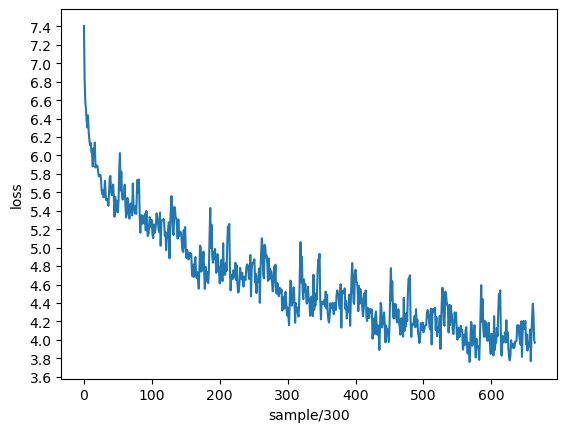

In [75]:
showPlot(loss)

In [77]:
def evaluate(encoder, decoder, sentence, input_lang, max_length=13):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(input_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
        decoded_words =  ' '.join(decoded_words[:-1])
        return decoded_words


In [83]:
random_indices = random.choices(range(len(data)), k=10)
for i, index in enumerate(random_indices):
    predicted_mesra = evaluate(encoder, decoder, data[index][0], lang, max_length)
    print(f'{i+1}-')
    print('first Mesra:')
    print(data[index][0])
    print('generated Mesra:')
    print(predicted_mesra)
    print('actual Mesra:')
    print(data[index][1])
    print()
    print('--------------------------------------------')

1-
first Mesra:
بترسم همی زانک گردان سپهر
generated Mesra:
به فر و به چین و به مهر و مهر
actual Mesra:
بخواهد بریدن ز ما پاک مهر

--------------------------------------------
2-
first Mesra:
ز مردن مرا و ترا چاره نیست
generated Mesra:
که از دانش بهره جز از رنج نیست
actual Mesra:
درنگی تر از مرگ پتیاره نیست

--------------------------------------------
3-
first Mesra:
به ترکان چنین گفت کهرم که کار
generated Mesra:
که با لشکری شهریار
actual Mesra:
همین بودمان رنج در کارزار

--------------------------------------------
4-
first Mesra:
نگه کرد افراسیاب از کران
generated Mesra:
که بودند از دور باشد به خواب
actual Mesra:
چنین گفت با نامور مهتران

--------------------------------------------
5-
first Mesra:
چنین گفت آنکس که هستش بسند
generated Mesra:
که با فر و با فر و با فرهی
actual Mesra:
ببخش خداوند چرخ بلند

--------------------------------------------
6-
first Mesra:
که نپسندد او را به دین آوری
generated Mesra:
که از هر سویی مهتری
actual Mesra:
سر اندر نیارد به فرمانبری

----------------